In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from time import sleep as fallasleep
import os, sys
from tqdm import tqdm, trange

In [2]:
from src.colortools import color_box

# Import data from Kraken 
source: [https://www.kraken.com/]

In [3]:
import krakenex
from pykrakenapi import KrakenAPI

### Choice of coins
- Ethereum: smart contract that is powering lots of Dapps.
- BTC:      still has the crown of all crypto.
- XRP:      fastest transaction speed, that has the most potential being used within the financial institutions.
- ADA:      Cardano uses third-generation proof-of-state with a strong focus on sustainability, scalability, and transparency.
- DOT:      polkadot is a multichain network that aims to be the central network that connects to other network protocols.

In [4]:
api = krakenex.API()
k = KrakenAPI(api)
coins = ["ETH", "DOT", "DOGE", "ADA", "BTC", "SUSHI", "XRP", "MKR", "ALGO", "LINK", "XMR"]
coins = coins[:4]
gapmin= 1440
coins = [coin+"USD" for coin in coins]
df = {}
colormapper = {}
for _,coin in tqdm(enumerate(coins)):
    data, last = k.get_ohlc_data(coin, interval = gapmin, ascending = True)
    df[coin]=data.drop(['time', 'count'], axis=1)
    colormapper[coin] = color_box[_]
    fallasleep(1)


4it [00:05,  1.26s/it]


In [5]:
df_close = pd.DataFrame(columns=coins)
for coin in coins:
    df_close[coin] = df[coin]['close']

In [6]:
df_close.isna().sum()

ETHUSD       0
DOTUSD     236
DOGEUSD      0
ADAUSD       0
dtype: int64

In [7]:
df_close = df_close.dropna()
df_close.isna().sum()

ETHUSD     0
DOTUSD     0
DOGEUSD    0
ADAUSD     0
dtype: int64

In [8]:
df_close.head(3)

,ETHUSD,DOTUSD,DOGEUSD,ADAUSD
dtime,,,,
2020-08-18,422.62,3.1099,0.003511,0.137218
2020-08-19,407.57,2.9175,0.003403,0.129678
2020-08-20,416.20,2.9090,0.003442,0.134305


In [9]:
df_close_diff = df_close.apply(np.log).diff().dropna()
df_close_diff.head(3)

,ETHUSD,DOTUSD,DOGEUSD,ADAUSD
dtime,,,,
2020-08-19,-0.036261,-0.063863,-0.031357,-0.056516
2020-08-20,0.020953,-0.002918,0.011250,0.035059
2020-08-21,-0.070599,0.056341,-0.020193,-0.087043


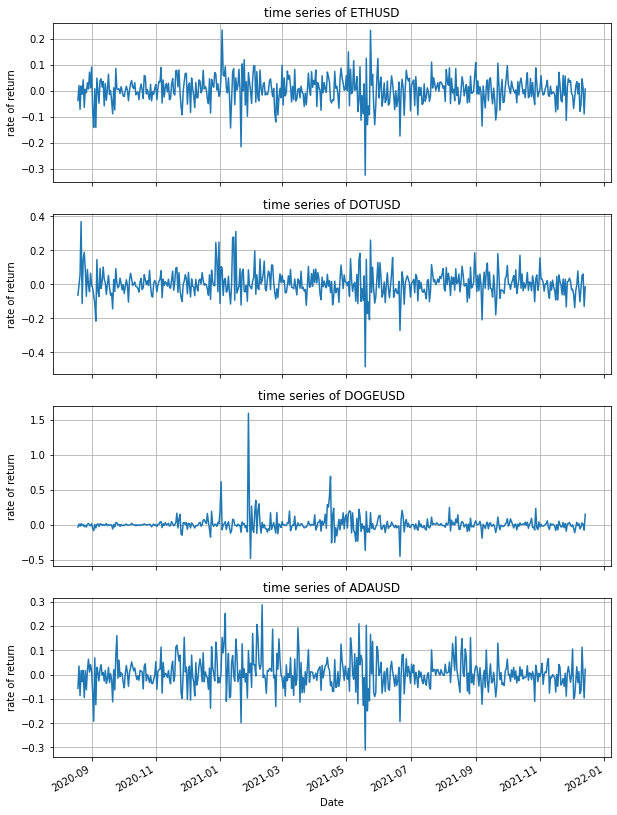

In [10]:
# fig = plt.figure(figsize=(8,6))
fig, ax = plt.subplots(len(df_close_diff.columns),1,figsize=(10,15))
for _,col in enumerate(df_close_diff):
    ax[_].plot(df_close_diff.index, df_close_diff[col].values)
    ax[_].set_title(f"time series of {col}")
    ax[_].set_ylabel("rate of return")
    ax[_].set_xlabel("Date")
    ax[_].grid()
fig.autofmt_xdate()
plt.show()

##### Mean-Variance Portfolio Optimization (cardinality constraint, no short selling)
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & (\textit{risk factor}) \times \frac{1}{2} x^TQx - r^Tx\\
& \text{subject to} && \mathbf{1}^Tx=k\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [11]:
Q = df_close_diff.cov().values
r = df_close_diff.mean().values

## Using Gurobi

In [12]:
from gurobipy import Model, GRB

In [13]:
def obj_val(x):
    return 0.5 * lam * (x @ Q @ x) - (r @ x)

def obj_val_qubo(x):
    return 0.5 * lam * (x @ Q @ x) - (r @ x) + P * (sum(x) - k) ** 2

def print_bold(string, end=False):
    if end:
        print('\033[91m' + '\033[1m' + string + '\033[0m',end="")
    else:
        
        print('\033[91m' + '\033[1m' + string + '\033[0m')

In [14]:
def obj_val_ising(z):
    return z@J@z + h@z + C

def qubo_to_ising(x):
    def x_to_z(x):
        return 1-2*x
    return [x_to_z(s) for s in x]

In [15]:
m   = Model("MVO")
x   = {}
n   = len(Q)
lam = 0.5
k   = 3
x   = m.addMVar(shape=n,vtype=GRB.BINARY, name=coins)
obj = lam * 0.5 * (x @ Q @ x) - (r @ x)
m.addConstr(x.sum()==k)
m.setObjective(obj, GRB.MINIMIZE)
m.optimize()

selected = []
gurobi   = []
for v in m.getVars():
    gurobi.append(int(v.x))
    if v.x == 1:
        selected.append(v.VarName)
print(f"Gurobi selected:         {selected}")
print(f"Gurobi optimal solution: {gurobi}")
print(f"Gurobi optimal value:    {obj_val(gurobi)}")

Restricted license - for non-production use only - expires 2023-10-25
Gurobi Optimizer version 9.5.0 build v9.5.0rc5 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1 rows, 4 columns and 4 nonzeros
Model fingerprint: 0x74e9248a
Model has 10 quadratic objective terms
Variable types: 0 continuous, 4 integer (4 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [4e-03, 8e-03]
  QObjective range [1e-03, 7e-03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 3e+00]
Found heuristic solution: objective -0.0073705
Presolve time: 0.00s
Presolved: 7 rows, 10 columns, 22 nonzeros
Variable types: 0 continuous, 10 integer (10 binary)

Root relaxation: objective -8.360249e-03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0            

## Using Qiskit

In [16]:
from qiskit                                   import Aer
from qiskit.algorithms                        import QAOA, NumPyMinimumEigensolver
from qiskit.algorithms.optimizers             import COBYLA
from qiskit.utils                             import QuantumInstance
from qiskit_finance.applications.optimization import PortfolioOptimization
from qiskit_optimization.algorithms           import MinimumEigenOptimizer, RecursiveMinimumEigenOptimizer
from qiskit_optimization.converters           import QuadraticProgramToQubo
from qiskit.utils                             import algorithm_globals

##### Mean-Variance Optimization (with cardinality constraint, no short selling), QUBO 
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & (\textit{risk factor}) \times \frac{1}{2} x^TQx - r^Tx +  P \cdot (\mathbf{1}^Tx - k)^2\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

In [17]:
portfolio = PortfolioOptimization(expected_returns=r, covariances=0.5*Q,
                                  risk_factor=lam, budget=k)
qp = portfolio.to_quadratic_program()
num_qubits = n
seed = 6969

### QAOA

In [18]:
def selection_to_picks(num_assets, selection):
    purchase = []
    for i in range(num_assets):
        if selection[i] == 1:
            purchase.append(coins[i])
    return purchase

def index_to_selection(i, n):
    s = "{0:b}".format(i).rjust(n)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(n))])
    return x

def print_result(result):
    selection = result.x
    value = result.fval
    print('Optimal: selection {}, value {:.6f}'.format(selection, value))
    
    eigenstate = result.min_eigen_solver_result.eigenstate
    eigenvector = eigenstate if isinstance(eigenstate, np.ndarray) else eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    states, values, probs = [], [], []
    for i in i_sorted:
        x = index_to_selection(i, n)
        value = QuadraticProgramToQubo().convert(qp).objective.evaluate(x)
        #value = portfolio.to_quadratic_program().objective.evaluate(x)
        probability = probabilities[i]
        if (x == gurobi).all():
            print_bold('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        else:
            print('%10s\t%.6f\t\t%.6f' %(x, value, probability))
        states.append(''.join(str(i) for i in x))
        values.append(value)
        probs.append(probability)
    return selection, states, values, probs

In [19]:
algorithm_globals.random_seed = seed
backend = Aer.get_backend('statevector_simulator')

cobyla = COBYLA()
cobyla.set_options(maxiter=2500)
quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, 
                                   seed_transpiler=seed)
qaoa_mes = QAOA(optimizer=cobyla, reps=3,
                quantum_instance=quantum_instance)
exact_mes = NumPyMinimumEigensolver()

qaoa = MinimumEigenOptimizer(qaoa_mes)
exact = MinimumEigenOptimizer(exact_mes)
rqaoa = RecursiveMinimumEigenOptimizer(qaoa, min_num_vars=2**num_qubits, 
                                       min_num_vars_optimizer=exact)
result = rqaoa.solve(qp)
print(result)
# selection, state, values, probabilities = print_result(result)
selection = result.x


print(f"QAOA selected:         {selection_to_picks(n, selection)}")
print(f"QAOA solution: {selection}")
print(f"QAOA value:    {obj_val(selection)}")

optimal function value: -0.0083602491691859
optimal value: [1. 0. 1. 1.]
status: SUCCESS
QAOA selected:         ['ETHUSD', 'DOGEUSD', 'ADAUSD']
QAOA solution: [1. 0. 1. 1.]
QAOA value:    -0.0083602491691859


### Circuit Design

In [20]:
from qiskit import QuantumCircuit, execute
from qiskit.circuit import Parameter

In [21]:
from mpl_toolkits import mplot3d
from matplotlib import cm

### Mean-Variance Optimization (cardinality constraint) - Unconstrained - BUY/NOT BUY

let $\textit{risk factor} = \lambda$, then we have our QUBO formulation for our problem
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & \frac{\lambda}{2} x^TQx - r^Tx +  P \cdot (\mathbf{1}^Tx - k)^2\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

Here, we set $P = \mathbb{E}[r^Tx - \frac{\lambda}{2}x^TQx]$

The corresponding QUBO formulation for our problem is as follows:
$$
\begin{aligned}
& \underset{x}{\text{minimize}} & & x^T \left[\frac{\lambda}{2}Q + P\mathbf{1} \mathbf{1}^T \right] x + \left[-r - 2Pk\mathbf{1} \right]^T x + C\\
        &&& x \in \{0,1\}\\
\end{aligned}
$$

where $C=k^2P$.

#### Corresponding Ising Model

define a new variable $z$ such that $x = \frac{1-z}{2}$, so $z \in \{-1, 1\}$

$$
\begin{aligned}
& \underset{z}{\text{minimize}} & & z^T \left[\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbf{1}\mathbf{1}^T\right)\right]z
+ \frac{1}{2}\left[r + 2kP\mathbf{1} -\textbf{1}^T(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T) \right]^Tz
+ C\\
        &&& z \in \{-1,1\}\\
\end{aligned}
$$

where $C=k^2P - \frac{1}{2}(r+2kP\mathbb{1})^T\mathbb{1} + 1^T\left[\frac{1}{4}(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T)\right]^T\mathbb{1}$.

#### Corresponding Hamiltonian
let $J =\frac{1}{4}\left(\frac{\lambda}{2}Q+P\mathbf{1}\mathbf{1}^T\right)$, and let $h = \frac{1}{2}\left[r + 2kP\mathbf{1} - \mathbf{1}^T(\frac{\lambda}{2}Q+P\mathbb{1}\mathbb{1}^T) \right]$.

We have $U(\gamma,C)=e^{\sum_{i=1}^n \sum_{j=1}^n -\frac{i\pi\gamma}{2} J_{ij}z_i z_j \sum_{i=1}^n-\frac{i\pi \gamma h_i}{2}z_i}$ $\quad$ or $\quad$ $U(\gamma,C)=\prod_{ij}e^{-\frac{i\pi\gamma}{2} J_{ij}z_i z_j} \prod_{i}e^{-\frac{i\pi \gamma }{2}h_{i} z_i}$

AND

$U(\beta,B)=e^{\frac{i\pi \beta}{2}B}$, where $B=\sum_{i=1}^n \sigma_x^i$ $\quad$ or $\quad$ $U(\beta,B)=\prod_{i=1}^n e^{\frac{i\pi \beta}{2}\sigma_x^i}$

Vanilla circuit layout

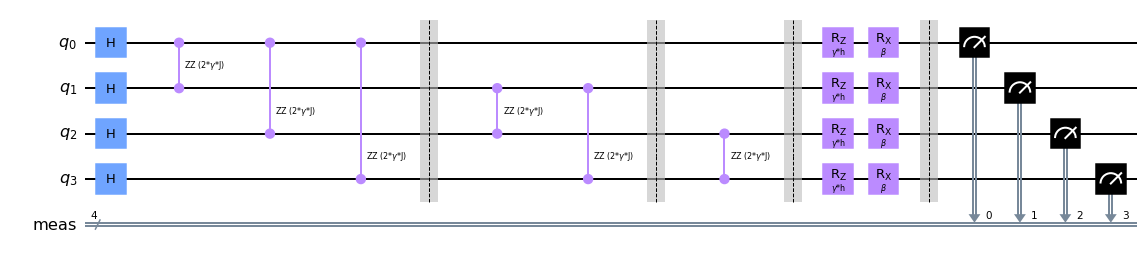

In [22]:
# we let b be beta and g be gamma for labeling
b = Parameter("$\\beta$")
g = Parameter("$\\gamma$")
jay = Parameter("J")
haitch = Parameter("h")

qc = QuantumCircuit(n)
# initial super position
for q in range(n):
    qc.h(q)

# phase separator
for i in range(n-1):
    for j in range(i+1,n):
        # factor of 2 because we are only taking the upper triangle
        # we don't need diagonal because state is either 1 or -1,;
        # square of either state is 1, so its relatively constant
        # to objective value
        qc.rzz(2*g*jay, i, j)
    qc.barrier()

for i in range(n):
    qc.rz(g * haitch, i)

# mixing operator
for i in range(n):
    # rotate i along the x axis by beta
    qc.rx(b, i)

# measure the state for each i
qc.measure_all()

# draw circuit
qc.draw('mpl')

In [23]:
P = -lam/2*np.min(Q)*k**2 + k*np.max(r)
P *= 7

J = 1/4 * (lam/2*Q + P*np.ones((n,n)))
h = 1/2 * (r + 2*k*P*np.ones(n) - np.ones(n).dot((lam/2*Q + P*np.ones((n,n)))))
C = k**2*P - 1/2*(r + 2*k*P*np.ones(n)).dot(np.ones(n)) + np.ones(n).dot(1/4*(lam/2*Q+P*np.ones((n,n)))).dot(np.ones(n))

check if the transformation is correct

In [24]:
x = gurobi
z = qubo_to_ising(x)
print(x)
print(z)
print(round(obj_val(x),8) == round(obj_val_ising(z),8))

[1, 0, 1, 1]
[-1, 1, -1, -1]
True


In [25]:
J.shape, h.shape, C.shape

((4, 4), (4,), ())

check if P is selected right

In [26]:
report = {}
for _ in range(2**n):
    count_format = format(_,'b')
    if len(count_format) < n:
        count_format = '0' * (n-len(count_format)) + count_format
    count_array  = [int(s) for s in count_format]
    count_array  = np.array(count_array)
    count_state = qubo_to_ising(count_array)
    report[count_format] = [round(obj_val_qubo(count_array),6), round(obj_val_ising(count_state),6)]
report = {k: v for k, v in sorted(report.items(), key=lambda item: item[1])}
print("state  |   qubo   |     ising   |")
print('-'*34)
for count in report:
    text = f"{count}    | {round(report[count][0],5)}         "[:18]
    # text = text[:15]
    text += f"|    {round(report[count][1],5)}     "[:14]
    text += "|"
    count_array = [int(s) for s in count]
    if count_array == gurobi:
        print_bold(text)
    else:
        print(text)

state  |   qubo   |     ising   |
----------------------------------
1011    | -0.00836|    -0.00836 |
1110    | -0.00737|    -0.00737 |
0111    | -0.0069 |    -0.0069  |
1101    | -0.00607|    -0.00607 |
1010    | 0.1281  |    0.1281   |
1111    | 0.1285  |    0.1285   |
0011    | 0.12851 |    0.12851  |
0110    | 0.12925 |    0.12925  |
1001    | 0.12928 |    0.12928  |
1100    | 0.13015 |    0.13015  |
0101    | 0.13052 |    0.13052  |
0010    | 0.53699 |    0.53699  |
1000    | 0.53782 |    0.53782  |
0001    | 0.53813 |    0.53813  |
0100    | 0.53875 |    0.53875  |
0000    | 1.21869 |    1.21869  |


scale up so the weights are close to an integer

In [27]:
scalar = 10
J *= scalar
h *= scalar
C *= scalar

In [28]:
def get_qaoa_circuit(n,J,h, beta_list, gamma_list, p=1):
    
    qc = QuantumCircuit(n)

    for i in range(n):
        # super position all states
        qc.h(i)
    for _ in range(p):
        beta  = beta_list[_]
        gamma = gamma_list[_]

        for i in range(n-1):
            for j in range(i+1,n):
                # first, add CNOT gate from i to j
                # second, rotate j along the z axis by gamma
                # finally, add another CNOT gate from i to j
                qc.rzz(gamma * 2 * J[i][j], i, j)
            qc.barrier()
        
        for i in range(n):
            qc.rz(gamma * h[i], i)

        for i in range(n):
            # rotate i along the x axis by beta
            qc.rx(0.5*beta, i)
        
    # measure the state for each i
    qc.measure_all()

    return qc

def compute_expectation(counts):
    shots = sum(counts.values())
    expectation_val = 0
    for z, freq in counts.items():
        freq /= shots
        z = [int(s) for s in z]
        obj = obj_val_qubo(z)
        expectation_val += freq * obj

    return expectation_val

def get_expectation(n,J,h,p=1, shots=2500, backend="statevector_simulator", set_seed=seed):
    backend = Aer.get_backend(backend)
    backend.shots = shots
    
    def execute_cir(param):
        param_half = int(len(param)/2)
        beta_list  = param[:param_half]
        gamma_list = param[param_half:]
        circuit = get_qaoa_circuit(n,J,h,beta_list,gamma_list,p)
        counts = backend.run(circuit, seed_simulator=seed, nshots=shots).result().get_counts()
        return compute_expectation(counts)
    return execute_cir


def shift_cor(text_cordinate, hshift, vshift, n):
    _b, _g = text_cordinate
    if _g < n*0.5:
        text_cordinate[1] +=  vshift
    elif _g > n*0.5:
        text_cordinate[1] -= vshift
    if _b < n*0.5:
        text_cordinate[0] += hshift
    elif _b > n*0.5:
        text_cordinate[0] -= hshift
    text_cordinate = tuple(text_cordinate)
    return text_cordinate

### Try grid search to find a good guess for the parameter pair $\beta$ and $\gamma$ with dept $p=1$

In [29]:


# iter_list = np.arange(-2*np.pi, 2*np.pi, 1/20)
iter_list = np.arange(0, 2*np.pi, 1/20)
iter_list_len = len(iter_list)
expectation = np.zeros((iter_list_len,iter_list_len))
depth = 1
shots = 10000
# backend_sim = "statevector_simulator"
backend_sim = "qasm_simulator"

# set expectation function
Expectation = get_expectation(n,J,h,p=1, shots=shots, backend=backend_sim, set_seed=seed)

param_iter_list = np.array([[g,b]for g in iter_list for b in iter_list ])
_b, _g = 0, 0
for _, (gamma, beta) in enumerate(tqdm(param_iter_list)):
    beta_list = [beta] * depth
    gamma_list = [gamma] * depth
    _b = _ % iter_list_len
    _g = _ // iter_list_len
    expectation[_g][_b] = Expectation(beta_list+gamma_list)
    # break

100%|██████████████████████████████████████████████████████████████████████████████████| 15876/15876 [01:13<00:00, 216.09it/s]


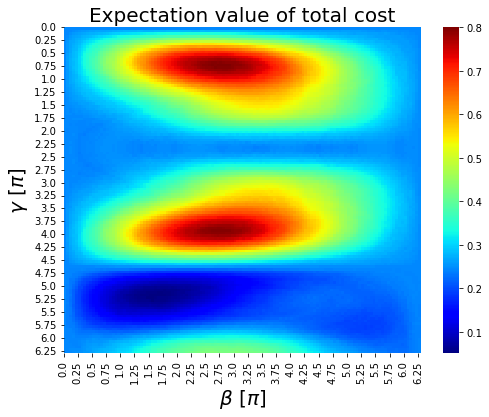

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(expectation, cbar=True, cmap='jet')
ax.set_title('Expectation value of total cost',size=20)
ax.set_ylabel(r'$\gamma \ [\pi]$',size=20)
ax.set_xlabel(r'$\beta \ [\pi]$',size=20)

loc = ticker.MultipleLocator(base=5)

# xticks for beta
ax.set_yticks(list(range(len(expectation[0]))))
ax.set_yticklabels(iter_list)

# yticks for gamma
ax.set_xticks(list(range(len(expectation[0]))))
ax.set_xticklabels(iter_list) # this locator puts ticks at regular intervals

# tick label freq as every 5 steps
ax.yaxis.set_major_locator(loc)
ax.xaxis.set_major_locator(loc)
text = r'''
        Figure {}: $\langle \psi(\gamma,\beta)|C(z)|\psi(\gamma,\beta) \rangle$ using input data.
        '''.format(1)
# plt.text(loc='bottom', ha='left', size=12)
plt.show()

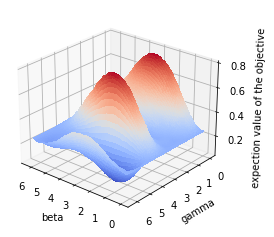

In [31]:
X = iter_list
Y = iter_list
X,Y = np.meshgrid(X,Y)

fit=plt.figure()
ax =plt.axes(projection='3d')
ax.plot_surface(X, Y, (expectation), rstride=1, cstride=1,
                cmap=cm.coolwarm, linewidth=0, antialiased=False)
ax.set_xlabel('beta')
ax.set_ylabel('gamma')
ax.set_zlabel('expection value of the objective')
ax.view_init(25, 130)
# ax.set_zlim([np.min(expected_loss)*1.5, np.max(expected_loss)])

plt.show()

We can see that our objective function is non-convex relative to the set of parameters. It can get very diffficult to find the optimal set of paremeters that would lead $\textit{close}$ to the optimal solution.

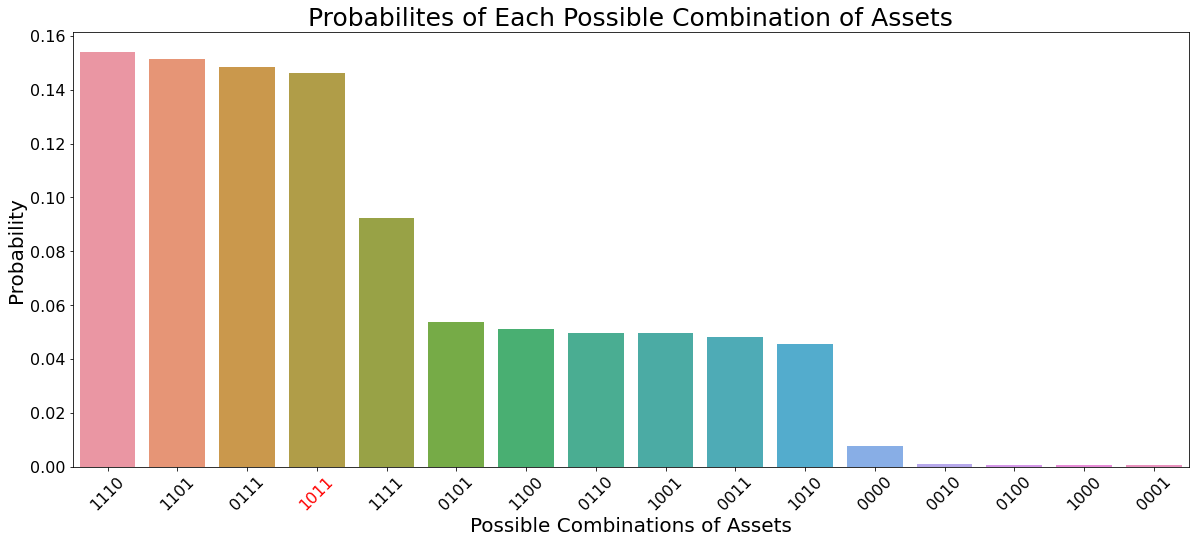

In [32]:
dept = 1
_g,_b = np.unravel_index(expectation.argmin(), expectation.shape)
b, g = iter_list[_b], iter_list[_g]
beta, gamma = [b]*depth, [g]*depth
qaoa_qc = get_qaoa_circuit(n,J,h,beta,gamma,p=depth)

# backend_sim = "statevector_simulator"
# backend_sim = "qasm_simulator"
backend = Aer.get_backend(backend_sim)
job     = execute(qaoa_qc, backend, shots = shots)
result  = job.result()
counts  = result.get_counts()
counts  ={k: v for k, v in sorted(counts.items(),
                                key=lambda item: item[1],
                                reverse=True)}

fig, ax = plt.subplots(figsize=(20, 8))
state = list(counts.keys())
freq  = list(counts.values())
freq  = [f/shots for f in freq]
optimized_value = sns.barplot(x=state, y=freq)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title("Probabilites of Each Possible Combination of Assets", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

using the grid search is applicable for a small size problem, but for a deeper circuits we need a better way to find the parameters. We will come back to this later.

We will optimize the parameters using classical algorithm that will minimize the expectation value of our cost function (Hamiltonian) using the Powell algorithm.

In [33]:
from scipy.optimize import minimize

In [34]:
def getConstraints(x):
    constraints = list()
    for _x in range(len(x)):
        constraints.append(
            {
                'type': 'ineq',
                'fun': lambda x: x[_x] # x[_x] >= 0
            })
        constraints.append({
                'type': 'ineq',
                'fun': lambda x: 2*np.pi-x[_x] # x[_x] <= 2pi
            })
    return constraints

def getBounds(x):
    bounds = [[0,2*np.pi] for _x in range(len(x))]
    return bounds

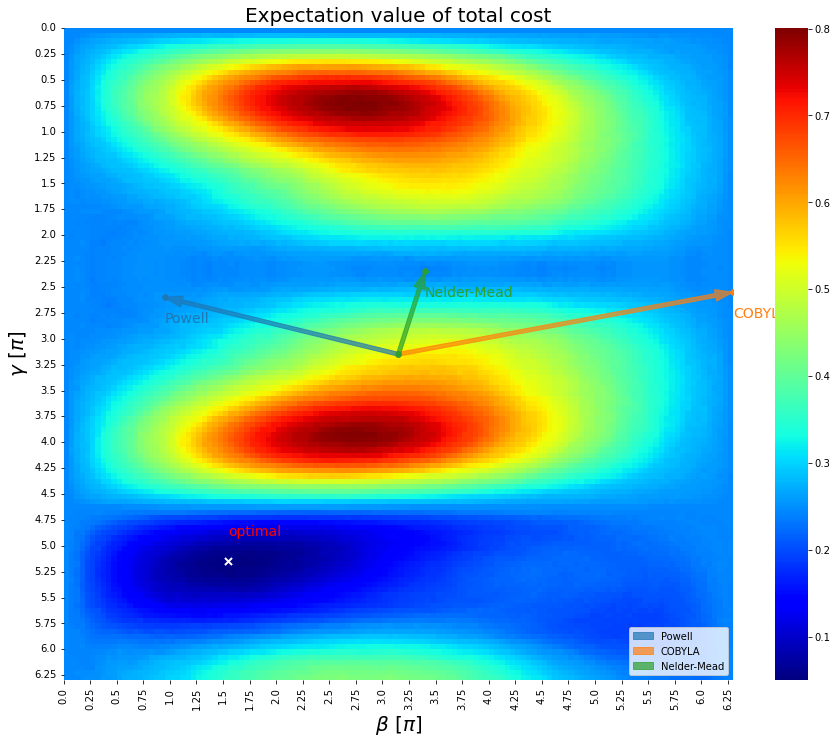

In [35]:
depth = 1

parameter_values = {}
optimizer = ['Powell', 'COBYLA', 'Nelder-Mead']
# backend_sim = "statevector_simulator"
# backend_sim = "qasm_simulator"
Expectation = get_expectation(n,J,h,p=1, shots=shots, backend=backend_sim, set_seed=seed)
for optim in optimizer:
    # We initiate our parameters beta and gamma using the optimal parameters found from brute force search with depth = 1
    beta_init, gamma_init =np.pi, np.pi
    
    param_init = [beta_init] * depth + [gamma_init] * depth
    if optim in ["Nelder-Mead", "Powell"]:
        res = minimize(Expectation, param_init, method=optim, bounds=getBounds(param_init))
    if optim in ["COBYLA"]:
        res = minimize(Expectation, param_init, method=optim, constraints=getConstraints(param_init))

    param_shift = [[param_init[_], res.x[_]] for _ in range(depth+1)]
    param_shift = [[sum(iter_list < param_shift[0][_]), sum(iter_list < param_shift[1][_])] for _ in [0, 1]]
    param_shift = [tuple(param_pair) for param_pair in param_shift]
    parameter_values[optim] = param_shift

fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(expectation, cbar=True, cmap='jet')
hshift, vshift = 0, 5

for _t ,optim in enumerate(parameter_values):
    param_shift = parameter_values[optim]
    for _, pair in enumerate(param_shift):
        label = f'iter {_}'
        if _ == len(param_shift)-1:
            label = 'final'
            text_cor = shift_cor(list(pair), hshift, vshift, iter_list_len)
            ax.text(*text_cor, optim, c=color_box[_t], size=14)
            
        ax.scatter(*pair, marker="o", s=20, c=color_box[_t], lw=2)#, label=label)
        if _ > 0:
            ax.arrow(*param_shift[_-1], 
                     dx = (param_shift[_][0] - param_shift[_-1][0]),
                     dy = (param_shift[_][1] - param_shift[_-1][1]),
                     width = 0.75, color=color_box[_t], length_includes_head = True,
                     label = optim, alpha = 0.7)

ax.scatter(_b, _g, marker="x", s=50, c='white', lw=2)
text_cor = [_b, _g]

text_cor = shift_cor(text_cor, hshift, vshift, iter_list_len)
ax.text(*text_cor, 'optimal', c='red', size=14)

ax.set_title('Expectation value of total cost',size=20)
ax.set_ylabel(r'$\gamma \ [\pi]$',size=20)
ax.set_xlabel(r'$\beta \ [\pi]$',size=20)

loc = ticker.MultipleLocator(base=5)

# xticks for beta
ax.set_yticks(list(range(len(expectation[0]))))
ax.set_yticklabels(iter_list)

# yticks for gamma
ax.set_xticks(list(range(len(expectation[0]))))
ax.set_xticklabels(iter_list) # this locator puts ticks at regular intervals

# tick label freq as every 5 steps
ax.yaxis.set_major_locator(loc)
ax.xaxis.set_major_locator(loc)
plt.legend(loc='lower right')
plt.show()

In [36]:
depth = 3
# backend_sim = "statevector_simulator"
# backend_sim = "qasm_simulator"
Expectation = get_expectation(n,J,h,p=depth, shots=shots, backend=backend_sim, set_seed=seed)
# We initiate our parameters beta and gamma using the optimal parameters found from brute force search with depth = 1
# optim = "Powell"
optim = "COBYLA"
# optim = "Nelder-Mead"
beta_init, gamma_init = np.pi, np.pi # b,g # np.pi, 1.5*np.pi
param_init = [beta_init] * depth + [gamma_init] * depth
res = minimize(Expectation, param_init, method=optim)#, bounds=getBounds(param_init)) # removing the bounds as the function is periodic

In [37]:
param_opt = res.x
param_len = int(len(param_opt)/2)
beta = param_opt[:param_len]
gamma = param_opt[param_len:]

qaoa_qc = get_qaoa_circuit(n,J,h,beta,gamma,p=depth)
backend = Aer.get_backend(backend_sim)
job     = execute(qaoa_qc, backend, shots = shots, memory=True)
result  = job.result()
counts  = result.get_counts()
counts  ={k: v for k, v in sorted(counts.items(),
                                key=lambda item: item[1],
                                reverse=True)}

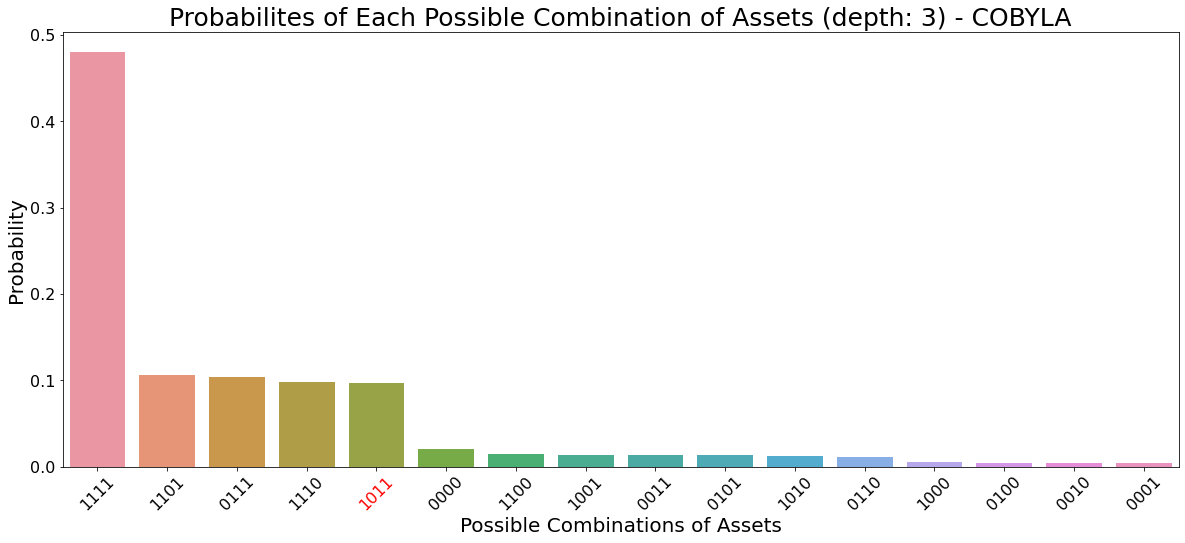

In [38]:
fig, ax = plt.subplots(figsize=(20, 8))
state = list(counts.keys())
freq  = list(counts.values())
freq  = [f/shots for f in freq]
optimized_value = sns.barplot(x=state, y=freq)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title(f"Probabilites of Each Possible Combination of Assets (depth: {depth}) - {optim}", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

### Let us take a look at the convergence of states vs the depth of the circuit using different optimizer

In [39]:
Depth = 20
objective_values = {}
parameter_values = {}
optimizer = ['Powell', 'COBYLA', 'Nelder-Mead']
optimal_solver = str()
optimal_state  = None
optimal_obj    = float('inf')
for optim in optimizer:
    objective_value = []
    parameter_value = []
    for _,depth in enumerate(t:=trange(1,Depth+1)):
        # backend_sim = "statevector_simulator"
        # backend_sim = "qasm_simulator"
        Expectation = get_expectation(n,J,h,p=depth, shots=shots, backend=backend_sim, set_seed=seed)
        
        # use the optimal parameter from the previous search as the starting point
        if _ == 0:
            param_init = [beta_init] + [gamma_init]
            beta  = [beta_init]
            gamma = [gamma_init]
            param_opt = beta + gamma
        else:
            # res = minimize(expectation, param_init, method=optim)
            if optim in ["Nelder-Mead", "Powell"]:
                res = minimize(Expectation, param_init, method=optim)#, bounds=getBounds(param_init))
            if optim in ["COBYLA"]:
                res = minimize(Expectation, param_init, method=optim)#, constraints=getConstraints(param_init))

            param_opt = res.x
            param_len = int(len(param_opt)/2)
            beta = param_opt[:param_len]
            gamma = param_opt[param_len:]

        qaoa_qc = get_qaoa_circuit(n,J,h,beta,gamma,p=depth)
        backend = Aer.get_backend(backend_sim)
        job     = execute(qaoa_qc, backend, shots = shots, memory=True)
        result  = job.result()
        counts  = result.get_counts()
        counts  ={k: v for k, v in sorted(counts.items(),
                                        key=lambda item: item[1],
                                        reverse=True)}
        
        if compute_expectation(counts) < optimal_obj:
            optimal_state = counts
            optimal_solver = optim
            optimal_obj = compute_expectation(counts)
        
        objective_value.append(compute_expectation(counts))
        parameter_value.append(param_opt)
        
        # update the initial parameter guess for the next iteration 
        # using the optimal pair with the initial guess being the same set of parameters
        # from the one depth prior but with a repeated parameter for the last depth
        param_init = np.concatenate((np.append(beta, b), np.append(gamma, g)), axis=0)
        
        t.set_description(f"optimal: {obj_val_qubo(gurobi):.5f}, optimizer: {optim}, best obj: {compute_expectation(counts):.5f}")
        
    objective_values[optim] = objective_value
    parameter_values[optim] = parameter_value

optimal: -0.00836, optimizer: Powell, best obj: -0.00308: 100%|███████████████████████████████| 20/20 [10:46<00:00, 32.32s/it]
optimal: -0.00836, optimizer: COBYLA, best obj: -0.00272: 100%|███████████████████████████████| 20/20 [00:49<00:00,  2.48s/it]
optimal: -0.00836, optimizer: Nelder-Mead, best obj: 0.00783: 100%|███████████████████████████| 20/20 [02:17<00:00,  6.86s/it]


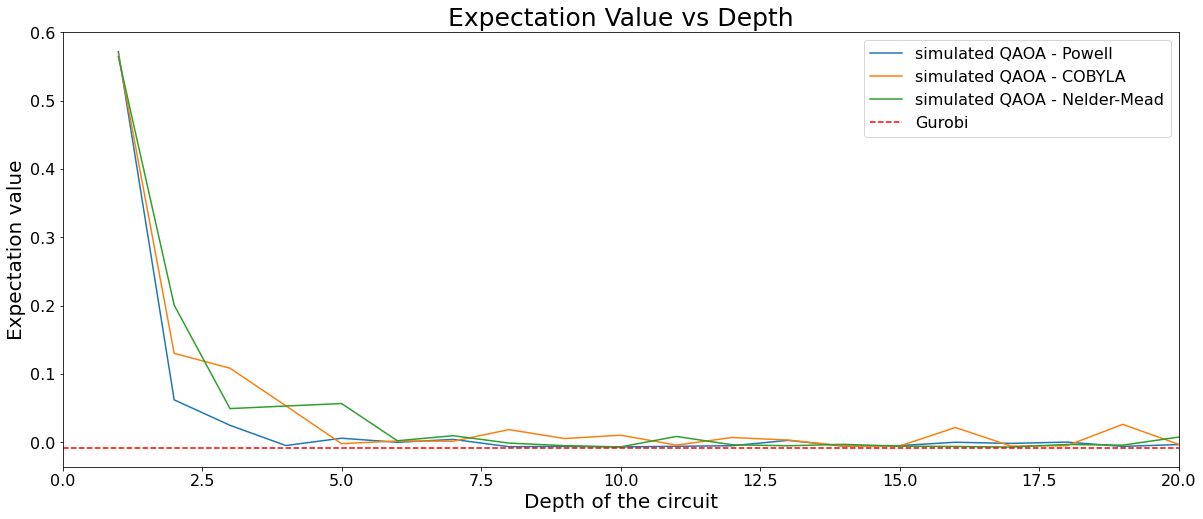

In [40]:
fig, ax = plt.subplots(figsize=(20, 8))
for _,optim in enumerate(optimizer):
    ax.plot(range(1,Depth+1), objective_values[optim], label=f'simulated QAOA - {optim}', c=color_box[_])
ax.axhline(obj_val_qubo(gurobi), xmin=0, xmax = Depth+1, ls='--', c='red', label='Gurobi')

ax.set_title("Expectation Value vs Depth", fontsize=25)
ax.set_xlabel('Depth of the circuit',fontsize =20)
ax.set_ylabel('Expectation value',fontsize = 20)
ax.set_xlim([0,Depth])
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)
plt.legend(loc='upper right', fontsize=16)
plt.show()

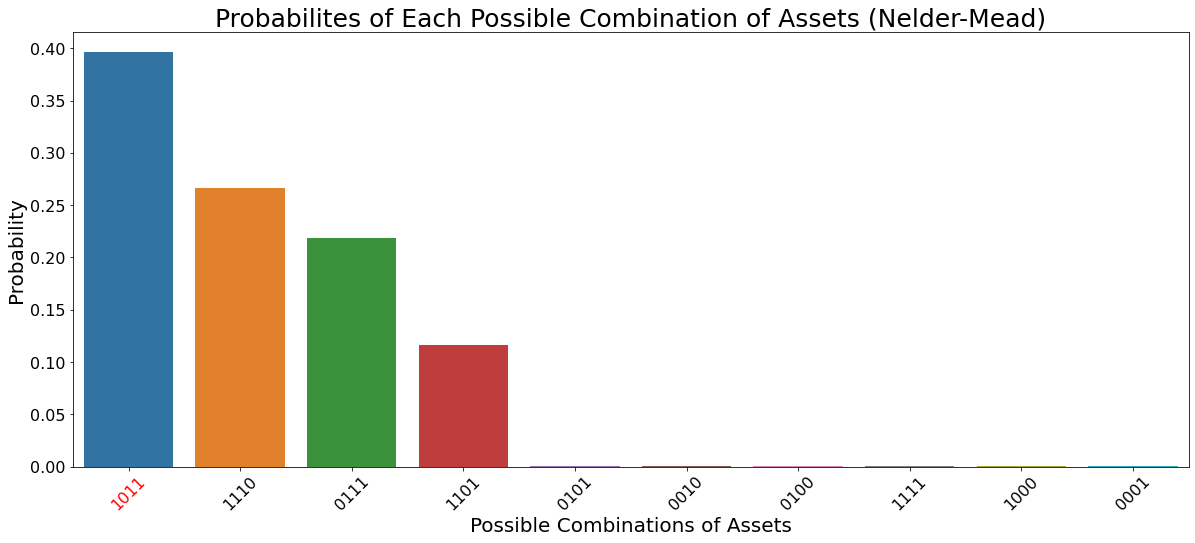

In [41]:
fig, ax = plt.subplots(figsize=(20, 8))
state = list(optimal_state.keys())
freq  = list(optimal_state.values())
freq  = [f/shots for f in freq]
optimized_value = sns.barplot(x=state, y=freq)
for _,item in enumerate(optimized_value.get_xticklabels()):
    item.set_rotation(45)
    if item.get_text() == ''.join(str(s) for s in gurobi):
        ax.get_xticklabels()[_].set_color("red")
ax.set_title(f"Probabilites of Each Possible Combination of Assets ({optimal_solver})", fontsize=25) # Probability of Max Return at given risk level
ax.set_xlabel('Possible Combinations of Assets',fontsize =20)
ax.tick_params(axis='x',labelsize=16)
ax.tick_params(axis='y',labelsize=16)
ax.set_ylabel('Probability',fontsize = 20)
plt.show()

In [42]:
report = {}
for _ in range(2**n):
    count_format = format(_,'b')
    if len(count_format) < n:
        count_format = '0' * (n-len(count_format)) + count_format
    count_array  = [int(s) for s in count_format]
    count_array  = np.array(count_array)
    count_state = qubo_to_ising(count_array)
    report[count_format] = [round(obj_val_qubo(count_array),8), round(obj_val_ising(count_state),8)]
report = {k: v for k, v in sorted(report.items(), key=lambda item: item[1])}
print("state  |   qubo   |     ising   |")
print('-'*34)
for count in report:
    text = f"{count}    | {round(report[count][0],5)}         "[:18]
    # text = text[:15]
    text += f"|    {round(report[count][1],5)}     "[:14]
    text += "|"
    count_array = [int(s) for s in count]
    if count_array == gurobi:
        print_bold(text)
    else:
        print(text)

state  |   qubo   |     ising   |
----------------------------------
1011    | -0.00836|    -0.0836  |
1110    | -0.00737|    -0.07371 |
0111    | -0.0069 |    -0.06898 |
1101    | -0.00607|    -0.06066 |
1010    | 0.1281  |    1.28103  |
1111    | 0.12849 |    1.28495  |
0011    | 0.12851 |    1.28514  |
0110    | 0.12925 |    1.29251  |
1001    | 0.12928 |    1.29276  |
1100    | 0.13015 |    1.30151  |
0101    | 0.13052 |    1.3052   |
0010    | 0.53699 |    5.36991  |
1000    | 0.53782 |    5.37822  |
0001    | 0.53813 |    5.38129  |
0100    | 0.53875 |    5.38752  |
0000    | 1.21869 |    12.18689 |
